In [1]:
!pip3 install pandas
!pip3 install seaborn
!pip3 install --upgrade tensorflow-gpu
!pip3 install import-ipynb

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import math
import pickle
import time
import sys

import import_ipynb
import VariationalAutoencoderModel

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.losses import mse
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, mean_squared_error, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

%matplotlib inline

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable
importing Jupyter notebook from VariationalAutoencoderModel.ipynb
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


2022-04-27 11:36:23.171988: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-27 11:36:23.172011: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction = 0.333)
sess = tf.compat.v1.Session(config = tf.compat.v1.ConfigProto(gpu_options = gpu_options))

2022-04-27 11:36:24.274326: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-27 11:36:24.300295: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-27 11:36:24.300394: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-04-27 11:36:24.300472: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared obj

# Simple Home 1002 Camera Data Pre-Processing

In [3]:
# Benign traffic

s2_benign = pd.read_csv('nbaiot/SimpleHome_XCS7_1002_WHT_Security_Camera/benign_traffic.csv', encoding = "utf-8", sep = ',' ) 
df_s2_benign = s2_benign.copy(deep=True)

columns = list(df_s2_benign.columns)
chosen_columns = []
for column in columns:
    if column.find('L5') != -1:
        chosen_columns.append(column)
        
df_s2_benign = pd.DataFrame(df_s2_benign, columns = chosen_columns)  


# Mirai

s2_mirai_ack = pd.read_csv('nbaiot/SimpleHome_XCS7_1002_WHT_Security_Camera/mirai/ack.csv', encoding = "utf-8", sep = ',' ) 
df_s2_mirai_ack = s2_mirai_ack.copy(deep=True)
df_s2_mirai_ack = pd.DataFrame(df_s2_mirai_ack, columns = chosen_columns)

s2_mirai_scan = pd.read_csv('nbaiot/SimpleHome_XCS7_1002_WHT_Security_Camera/mirai/scan.csv', encoding = "utf-8", sep = ',' ) 
df_s2_mirai_scan = s2_mirai_scan.copy(deep=True)
df_s2_mirai_scan = pd.DataFrame(df_s2_mirai_scan, columns = chosen_columns)

s2_mirai_syn = pd.read_csv('nbaiot/SimpleHome_XCS7_1002_WHT_Security_Camera/mirai/syn.csv', encoding = "utf-8", sep = ',' ) 
df_s2_mirai_syn = s2_mirai_syn.copy(deep=True)
df_s2_mirai_syn = pd.DataFrame(df_s2_mirai_syn, columns = chosen_columns)

s2_mirai_udp = pd.read_csv('nbaiot/SimpleHome_XCS7_1002_WHT_Security_Camera/mirai/udp.csv', encoding = "utf-8", sep = ',' ) 
df_s2_mirai_udp = s2_mirai_udp.copy(deep=True)
df_s2_mirai_udp = pd.DataFrame(df_s2_mirai_udp, columns = chosen_columns)

s2_mirai_udpplain = pd.read_csv('nbaiot/SimpleHome_XCS7_1002_WHT_Security_Camera/mirai/udpplain.csv', encoding = "utf-8", sep = ',' ) 
df_s2_mirai_udpplain = s2_mirai_udpplain.copy(deep=True)
df_s2_mirai_udpplain = pd.DataFrame(df_s2_mirai_udpplain, columns = chosen_columns)

# Bashlite

s2_bashlite_combo = pd.read_csv('nbaiot/SimpleHome_XCS7_1002_WHT_Security_Camera/gafgyt/combo.csv', encoding = "utf-8", sep = ',' ) 
df_s2_bashlite_combo = s2_bashlite_combo.copy(deep=True)
df_s2_bashlite_combo = pd.DataFrame(df_s2_bashlite_combo, columns = chosen_columns)

s2_bashlite_junk = pd.read_csv('nbaiot/SimpleHome_XCS7_1002_WHT_Security_Camera/gafgyt/junk.csv', encoding = "utf-8", sep = ',' ) 
df_s2_bashlite_junk = s2_bashlite_junk.copy(deep=True)
df_s2_bashlite_junk = pd.DataFrame(df_s2_bashlite_junk, columns = chosen_columns)

s2_bashlite_scan = pd.read_csv('nbaiot/SimpleHome_XCS7_1002_WHT_Security_Camera/gafgyt/scan.csv', encoding = "utf-8", sep = ',' ) 
df_s2_bashlite_scan = s2_bashlite_scan.copy(deep=True)
df_s2_bashlite_scan = pd.DataFrame(df_s2_bashlite_scan, columns = chosen_columns)

s2_bashlite_udp = pd.read_csv('nbaiot/SimpleHome_XCS7_1002_WHT_Security_Camera/gafgyt/udp.csv', encoding = "utf-8", sep = ',' ) 
df_s2_bashlite_udp = s2_bashlite_udp.copy(deep=True)
df_s2_bashlite_udp = pd.DataFrame(df_s2_bashlite_udp, columns = chosen_columns)

s2_bashlite_tcp = pd.read_csv('nbaiot/SimpleHome_XCS7_1002_WHT_Security_Camera/gafgyt/tcp.csv', encoding = "utf-8", sep = ',' ) 
df_s2_bashlite_tcp = s2_bashlite_tcp.copy(deep=True)
df_s2_bashlite_tcp = pd.DataFrame(df_s2_bashlite_tcp, columns = chosen_columns)

In [4]:
scaler = MinMaxScaler()
df_s2_benign_norm = scaler.fit_transform(df_s2_benign)

df_s2_miraiack_norm = scaler.fit_transform(df_s2_mirai_ack)
df_s2_miraiscan_norm = scaler.fit_transform(df_s2_mirai_scan)
df_s2_miraisyn_norm = scaler.fit_transform(df_s2_mirai_syn)
df_s2_miraiudp_norm = scaler.fit_transform(df_s2_mirai_udp)
df_s2_miraiudpplain_norm = scaler.fit_transform(df_s2_mirai_udpplain)

df_s2_bashlitecombo_norm = scaler.fit_transform(df_s2_bashlite_combo)
df_s2_bashlitejunk_norm = scaler.fit_transform(df_s2_bashlite_junk)
df_s2_bashlitescan_norm = scaler.fit_transform(df_s2_bashlite_scan)
df_s2_bashliteudp_norm = scaler.fit_transform(df_s2_bashlite_udp)
df_s2_bashlitetcp_norm = scaler.fit_transform(df_s2_bashlite_tcp)

# Variational Autoencoder - Attack Detection

## Model

In [5]:
# Train set

len_benign = len(df_s2_benign_norm)
len_benign_train = int(0.7 * len_benign)
X_train_VAE = df_s2_benign_norm[:len_benign_train]

# Test set - 30% benign and the rest is attack

X_test_benign = df_s2_benign_norm[len_benign_train:]

len_attack_test = len(X_test_benign)
X_test_mirai_ack = df_s2_miraiack_norm
X_test_mirai_scan = df_s2_miraiscan_norm
X_test_mirai_syn = df_s2_miraisyn_norm
X_test_mirai_udp = df_s2_miraiudp_norm
X_test_mirai_udpplain = df_s2_miraiudpplain_norm
X_test_bashlite_combo = df_s2_bashlitecombo_norm
X_test_bashlite_junk = df_s2_bashlitejunk_norm
X_test_bashlite_scan = df_s2_bashlitescan_norm
X_test_bashlite_tcp = df_s2_bashlitetcp_norm
X_test_bashlite_udp = df_s2_bashliteudp_norm

X_test_VAE = np.concatenate([X_test_benign, X_test_mirai_ack, X_test_mirai_scan, X_test_mirai_syn, X_test_mirai_udp,
                             X_test_mirai_udpplain, X_test_bashlite_combo, X_test_bashlite_junk, X_test_bashlite_scan,
                             X_test_bashlite_tcp, X_test_bashlite_udp])

Y_test_VAE = np.ones(len(X_test_VAE))
Y_test_VAE[:len(X_test_benign)] = 0

In [6]:
# KL Loss function

def vae_loss(x, x_decoded_mean):
    # Compute the average MSE error, then scale it up (sum on all axes)
    
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean))
    
    # Compute the KL loss
    
    kl_loss = - 0.5 * K.sum(1 + z_var - K.square(z_mean) - K.square(K.exp(z_var)), axis=-1)
    
    # Return the average loss over all 
    
    total_loss = K.mean(reconstruction_loss + kl_loss) # Total_loss = reconstruction_loss + kl_loss 
    return total_loss

# (1) Reconstruction Loss - Forces the encoder to generate latent features that minimize the reconstruction error, or else is
# penalized
# (2) KL Loss - Forces the distribution generated by the encoder to be similar to the prior probability of the input vector, 
# pushing latent feature space to normality

In [7]:
# Parameters

original_dim = X_train_VAE.shape[1]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 2)
latent_dim = int(original_dim / 3)

epochs = 450
learning_rate = 0.00005
batch_size = 23
anomaly_threshold = 0.056
number_features = 23

In [8]:
# Encoder

inputs, encoder, z_var, z_mean = VariationalAutoencoderModel.vae_encoder(
    input_shape, 
    intermediate_dim, 
    latent_dim, 
    VariationalAutoencoderModel.sample)

encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 23)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 11)           264         ['encoder_input[0][0]']          
                                                                                                  
 z_mean (Dense)                 (None, 7)            84          ['dense[0][0]']                  
                                                                                                  
 z_var (Dense)                  (None, 7)            84          ['dense[0][0]']                  
                                                                                            

In [9]:
# Decoder

decoder = VariationalAutoencoderModel.vae_decoder(
    intermediate_dim,
    latent_dim,
    original_dim)

decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 7)]               0         
                                                                 
 dense_1 (Dense)             (None, 11)                88        
                                                                 
 dense_2 (Dense)             (None, 23)                276       
                                                                 
Total params: 364
Trainable params: 364
Non-trainable params: 0
_________________________________________________________________


In [10]:
# VAE model

outputs = decoder(encoder(inputs))

opt = optimizers.Adam(learning_rate = learning_rate, clipvalue = 0.5)

vae_model = Model(inputs, outputs, name = 'vae_mlp')
vae_model.compile(optimizer = opt, loss = vae_loss)
vae_model.summary()

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 23)]              0         
                                                                 
 encoder (Functional)        (None, 7)                 432       
                                                                 
 decoder (Functional)        (None, 23)                364       
                                                                 
Total params: 796
Trainable params: 796
Non-trainable params: 0
_________________________________________________________________


## Train

In [11]:
train_start = time.time()

results = vae_model.fit(X_train_VAE, X_train_VAE,
                        shuffle = True,
                        epochs = epochs,
                        batch_size = batch_size)

train_end = time.time()
train_time = train_end - train_start
print("Training time:", train_time)

Train on 32609 samples
Epoch 1/450


2022-04-27 11:36:35.616294: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


32609/32609 [==============================] - 3s 105us/sample - loss: 85.0679
Epoch 2/450
32609/32609 [==============================] - 3s 99us/sample - loss: 43.9575
Epoch 3/450
32609/32609 [==============================] - 3s 98us/sample - loss: 20.8271
Epoch 4/450
32609/32609 [==============================] - 3s 97us/sample - loss: 14.6066
Epoch 5/450
32609/32609 [==============================] - 3s 99us/sample - loss: 12.7368
Epoch 6/450
32609/32609 [==============================] - 3s 98us/sample - loss: 11.4755
Epoch 7/450
32609/32609 [==============================] - 3s 97us/sample - loss: 10.1378
Epoch 8/450
32609/32609 [==============================] - 3s 97us/sample - loss: 8.4586
Epoch 9/450
32609/32609 [==============================] - 3s 99us/sample - loss: 6.9583
Epoch 10/450
32609/32609 [==============================] - 3s 99us/sample - loss: 5.9855
Epoch 11/450
32609/32609 [==============================] - 3s 97us/sample - loss: 5.3431
Epoch 12/450
32609/3260

32609/32609 [==============================] - 3s 105us/sample - loss: 2.5775
Epoch 92/450
32609/32609 [==============================] - 3s 104us/sample - loss: 2.5504
Epoch 93/450
32609/32609 [==============================] - 3s 106us/sample - loss: 2.5458
Epoch 94/450
32609/32609 [==============================] - 3s 105us/sample - loss: 2.5528
Epoch 95/450
32609/32609 [==============================] - 3s 105us/sample - loss: 2.5264
Epoch 96/450
32609/32609 [==============================] - 3s 104us/sample - loss: 2.5507
Epoch 97/450
32609/32609 [==============================] - 3s 104us/sample - loss: 2.5357
Epoch 98/450
32609/32609 [==============================] - 3s 105us/sample - loss: 2.5477
Epoch 99/450
32609/32609 [==============================] - 3s 104us/sample - loss: 2.5289
Epoch 100/450
32609/32609 [==============================] - 3s 104us/sample - loss: 2.5186
Epoch 101/450
32609/32609 [==============================] - 3s 105us/sample - loss: 2.5175
Epoch 102/

32609/32609 [==============================] - 3s 81us/sample - loss: 2.2071
Epoch 182/450
32609/32609 [==============================] - 3s 81us/sample - loss: 2.2424
Epoch 183/450
32609/32609 [==============================] - 3s 81us/sample - loss: 2.1995
Epoch 184/450
32609/32609 [==============================] - 3s 81us/sample - loss: 2.2153
Epoch 185/450
32609/32609 [==============================] - 3s 81us/sample - loss: 2.2085
Epoch 186/450
32609/32609 [==============================] - 3s 81us/sample - loss: 2.2327
Epoch 187/450
32609/32609 [==============================] - 3s 82us/sample - loss: 2.2144
Epoch 188/450
32609/32609 [==============================] - 3s 81us/sample - loss: 2.2068
Epoch 189/450
32609/32609 [==============================] - 3s 81us/sample - loss: 2.2176
Epoch 190/450
32609/32609 [==============================] - 3s 81us/sample - loss: 2.2137
Epoch 191/450
32609/32609 [==============================] - 3s 81us/sample - loss: 2.1783
Epoch 192/450

32609/32609 [==============================] - 3s 79us/sample - loss: 2.1353
Epoch 272/450
32609/32609 [==============================] - 3s 80us/sample - loss: 2.1490
Epoch 273/450
32609/32609 [==============================] - 3s 79us/sample - loss: 2.1522
Epoch 274/450
32609/32609 [==============================] - 3s 80us/sample - loss: 2.1496
Epoch 275/450
32609/32609 [==============================] - 3s 80us/sample - loss: 2.1434
Epoch 276/450
32609/32609 [==============================] - 3s 79us/sample - loss: 2.1411
Epoch 277/450
32609/32609 [==============================] - 3s 80us/sample - loss: 2.1628
Epoch 278/450
32609/32609 [==============================] - 3s 79us/sample - loss: 2.1396
Epoch 279/450
32609/32609 [==============================] - 3s 80us/sample - loss: 2.1499
Epoch 280/450
32609/32609 [==============================] - 3s 79us/sample - loss: 2.1314
Epoch 281/450
32609/32609 [==============================] - 3s 79us/sample - loss: 2.1415
Epoch 282/450

32609/32609 [==============================] - 3s 81us/sample - loss: 2.2615
Epoch 362/450
32609/32609 [==============================] - 3s 80us/sample - loss: 2.2463
Epoch 363/450
32609/32609 [==============================] - 3s 80us/sample - loss: 2.2453
Epoch 364/450
32609/32609 [==============================] - 3s 80us/sample - loss: 2.2513
Epoch 365/450
32609/32609 [==============================] - 3s 80us/sample - loss: 2.2569
Epoch 366/450
32609/32609 [==============================] - 3s 79us/sample - loss: 2.2423
Epoch 367/450
32609/32609 [==============================] - 3s 80us/sample - loss: 2.2699
Epoch 368/450
32609/32609 [==============================] - 3s 80us/sample - loss: 2.2248
Epoch 369/450
32609/32609 [==============================] - 3s 80us/sample - loss: 2.2399
Epoch 370/450
32609/32609 [==============================] - 3s 80us/sample - loss: 2.2204
Epoch 371/450
32609/32609 [==============================] - 3s 80us/sample - loss: 2.2466
Epoch 372/450

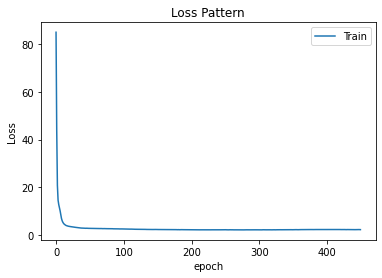

In [12]:
plt.plot(results.history['loss'])
plt.title('Loss Pattern')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper right');
plt.show()

## Test

In [13]:
X_train_pred = vae_model.predict(X_train_VAE)
error_vector = VariationalAutoencoderModel.get_error_term(X_train_pred, X_train_VAE, _rmse=False)
error_thresh = anomaly_threshold

# Measure the error between the train set and its output and generates an error vector representing the error of each term
# Find an extreme value on the vector to use as the error threshold

/home/andressa.amaral/.local/lib/python3.7/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [14]:
test_start = time.time()

X_pred_VAE = vae_model.predict(X_test_VAE)

test_end = time.time()
test_time = test_end - test_start
print("Testing time:", test_time)

# If the error of the vector is higher than the defined threshold it detects an attack

error_vector = VariationalAutoencoderModel.get_error_term(X_pred_VAE, X_test_VAE, _rmse=False)
attacks = (error_vector > error_thresh)
print(attacks)

np.count_nonzero(attacks) / len(attacks) # Percentage of attacks

Testing time: 22.368398904800415
[False False False ...  True  True  True]


0.9836461568287922

In [15]:
print(len(X_test_VAE))

830447


## Metrics

In [16]:
sys.stdout = open("Results/S1002_camera.txt", "a")

print(" ==== Test " + str(number_features) + " Normal learning rate ====")
print("Training time:" + str(train_time))
print("Testing time:" + str(test_time))
print(classification_report(Y_test_VAE, attacks, digits = 5))

In [17]:
# Examinig the latent space generated by the encoder

X_encoded = encoder.predict(X_test_VAE)

pca = PCA(n_components=2)
X_analysis = pca.fit_transform(X_encoded)

/home/andressa.amaral/.local/lib/python3.7/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [18]:
'''plt.figure(figsize = (12, 10))
sns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = error_vector)
plt.grid()
plt.show()

# Darker clusters indicate that the error is higher'''

'plt.figure(figsize = (12, 10))\nsns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = error_vector)\nplt.grid()\nplt.show()\n\n# Darker clusters indicate that the error is higher'

In [19]:
'''plt.figure(figsize=(12, 10))
sns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = attacks)
plt.grid()
plt.show()

# Orange ones are anomalies'''

'plt.figure(figsize=(12, 10))\nsns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = attacks)\nplt.grid()\nplt.show()\n\n# Orange ones are anomalies'

In [20]:
'''plt.figure(figsize = (12, 10))
sns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = Y_test_VAE)
plt.grid()
plt.show()

# Ground truth'''

'plt.figure(figsize = (12, 10))\nsns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = Y_test_VAE)\nplt.grid()\nplt.show()\n\n# Ground truth'